# OpenSeeD embedding test
This notebook demonstrates how to obtain text and pixel embeddings using the utilities in the `tools` package.

✅ Imports and paths set up successfully.

--- Loading Custom Model (openseed_inference.py) ---
self.task_switch  {'coco': True, 'o365': True}


$UNUSED$ sem_seg_head.predictor.query_embed.weight, Ckpt Shape: torch.Size([100, 4])
$UNUSED$ sem_seg_head.predictor.query_feat.weight, Ckpt Shape: torch.Size([100, 256])



--- Loading Original Demo Model (Replicating demo_semseg.py logic) ---
self.task_switch  {'coco': True, 'o365': True}


$UNUSED$ sem_seg_head.predictor.query_embed.weight, Ckpt Shape: torch.Size([100, 4])
$UNUSED$ sem_seg_head.predictor.query_feat.weight, Ckpt Shape: torch.Size([100, 256])



✅ Models loaded on cuda
✅ Selected 6 images for testing.

🖼️  Processing Image 1/6: 5LpN3gDmAk7_724.png
--> Results from both scripts are identical: True


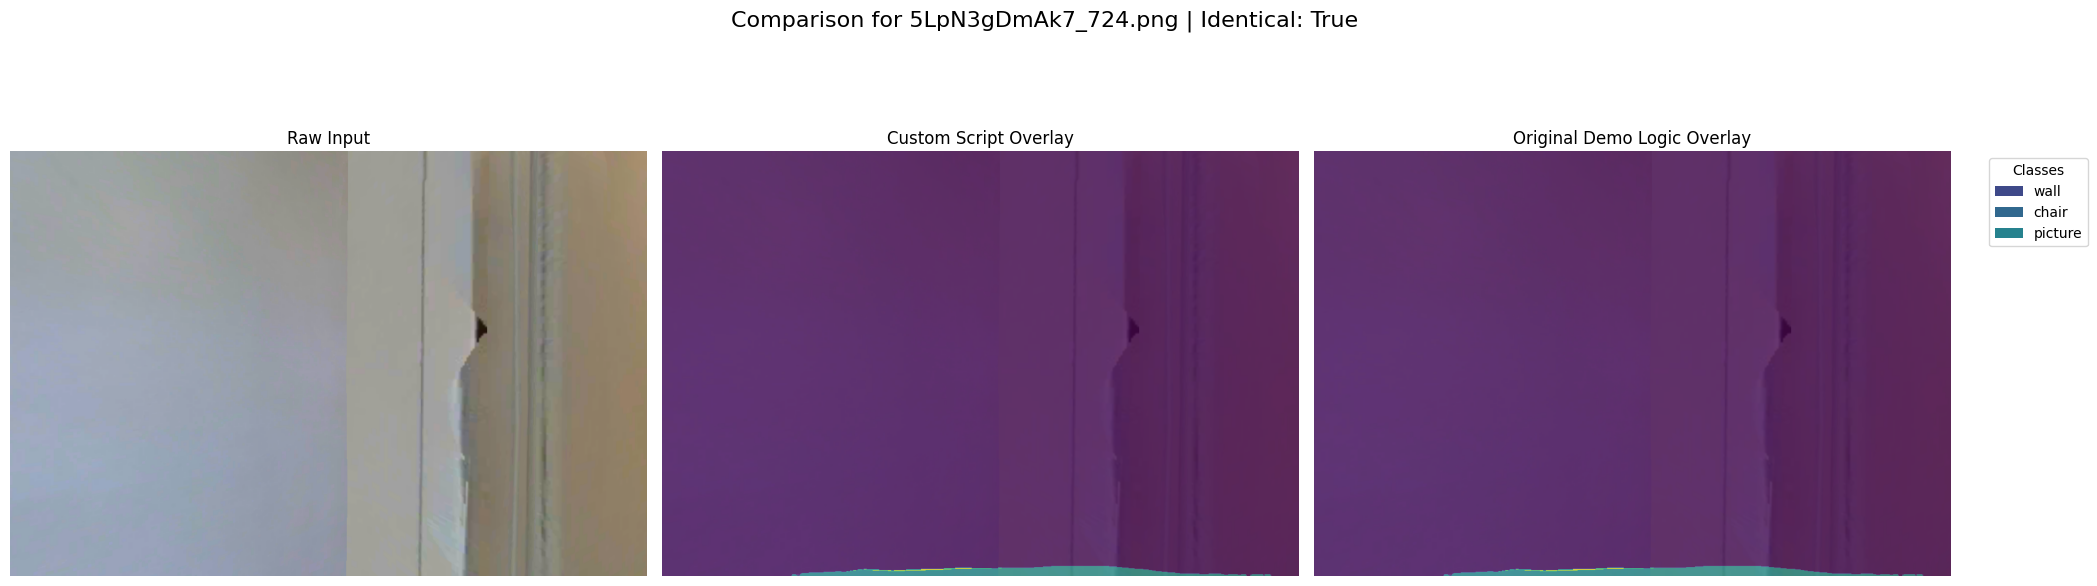


🖼️  Processing Image 2/6: 5LpN3gDmAk7_967.png
--> Results from both scripts are identical: True


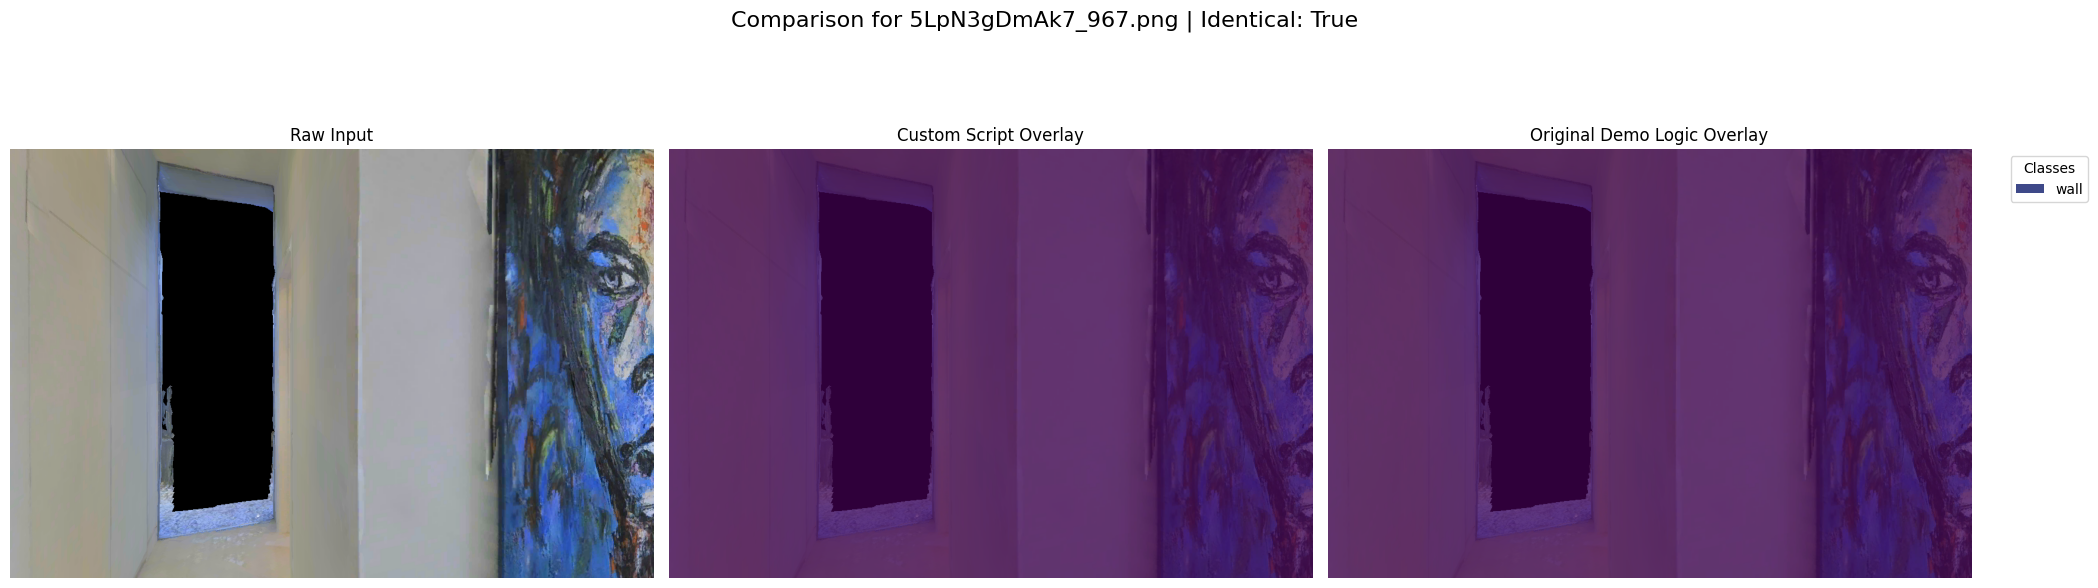


🖼️  Processing Image 3/6: 5LpN3gDmAk7_703.png
--> Results from both scripts are identical: True


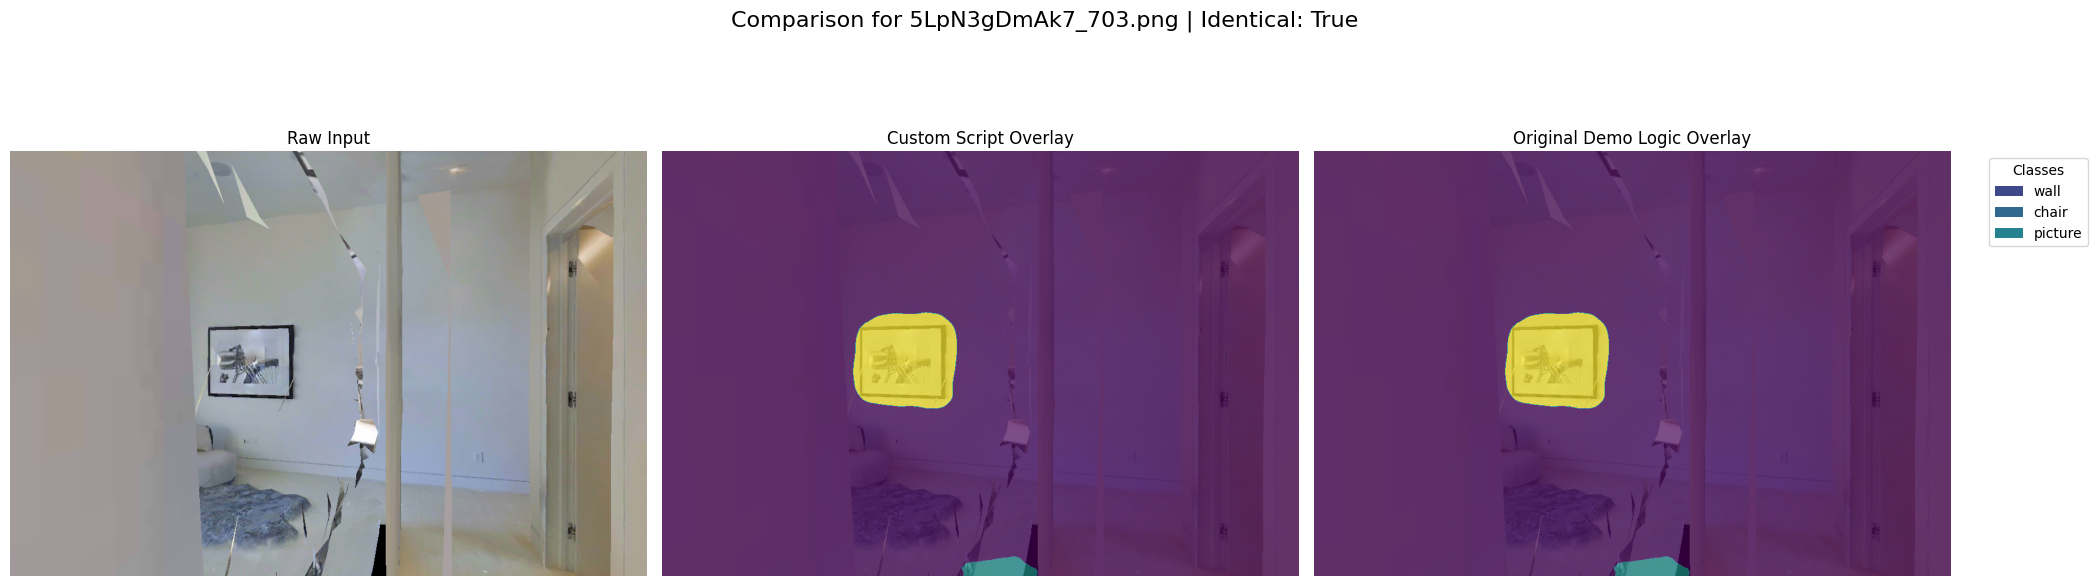


🖼️  Processing Image 4/6: 5LpN3gDmAk7_225.png
--> Results from both scripts are identical: True


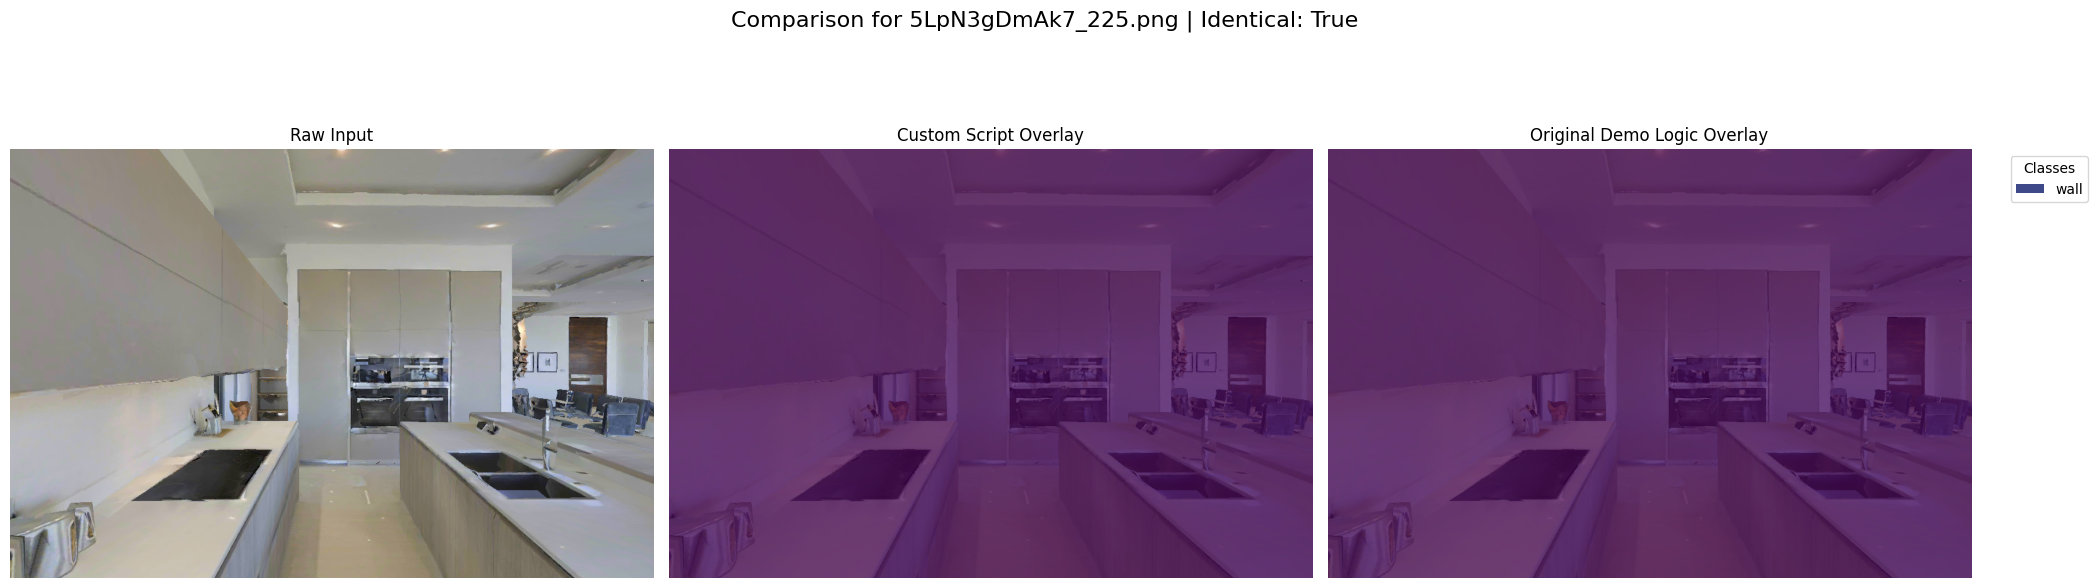


🖼️  Processing Image 5/6: 5LpN3gDmAk7_864.png
--> Results from both scripts are identical: True


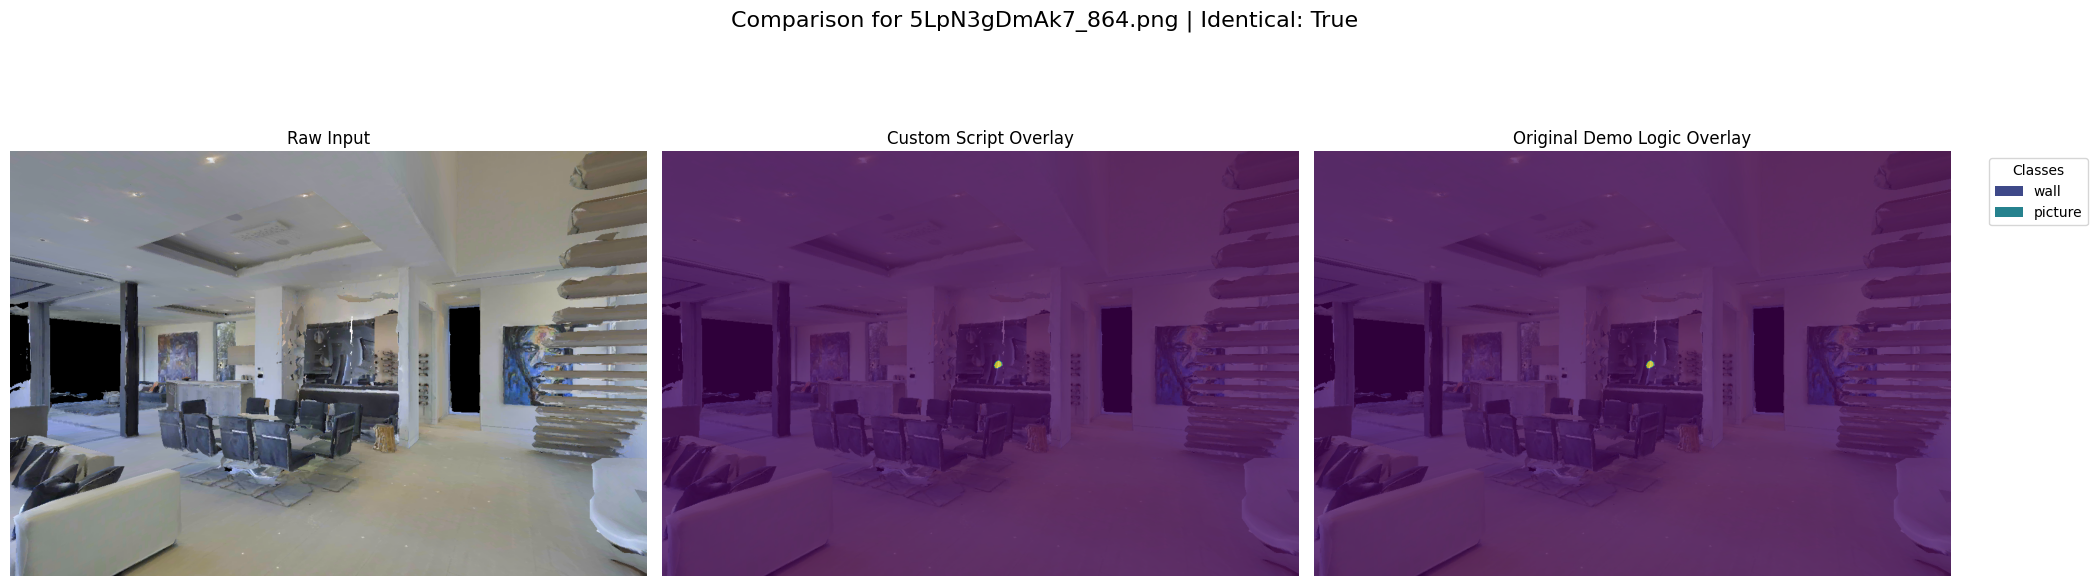


🖼️  Processing Image 6/6: 5LpN3gDmAk7_979.png
--> Results from both scripts are identical: True


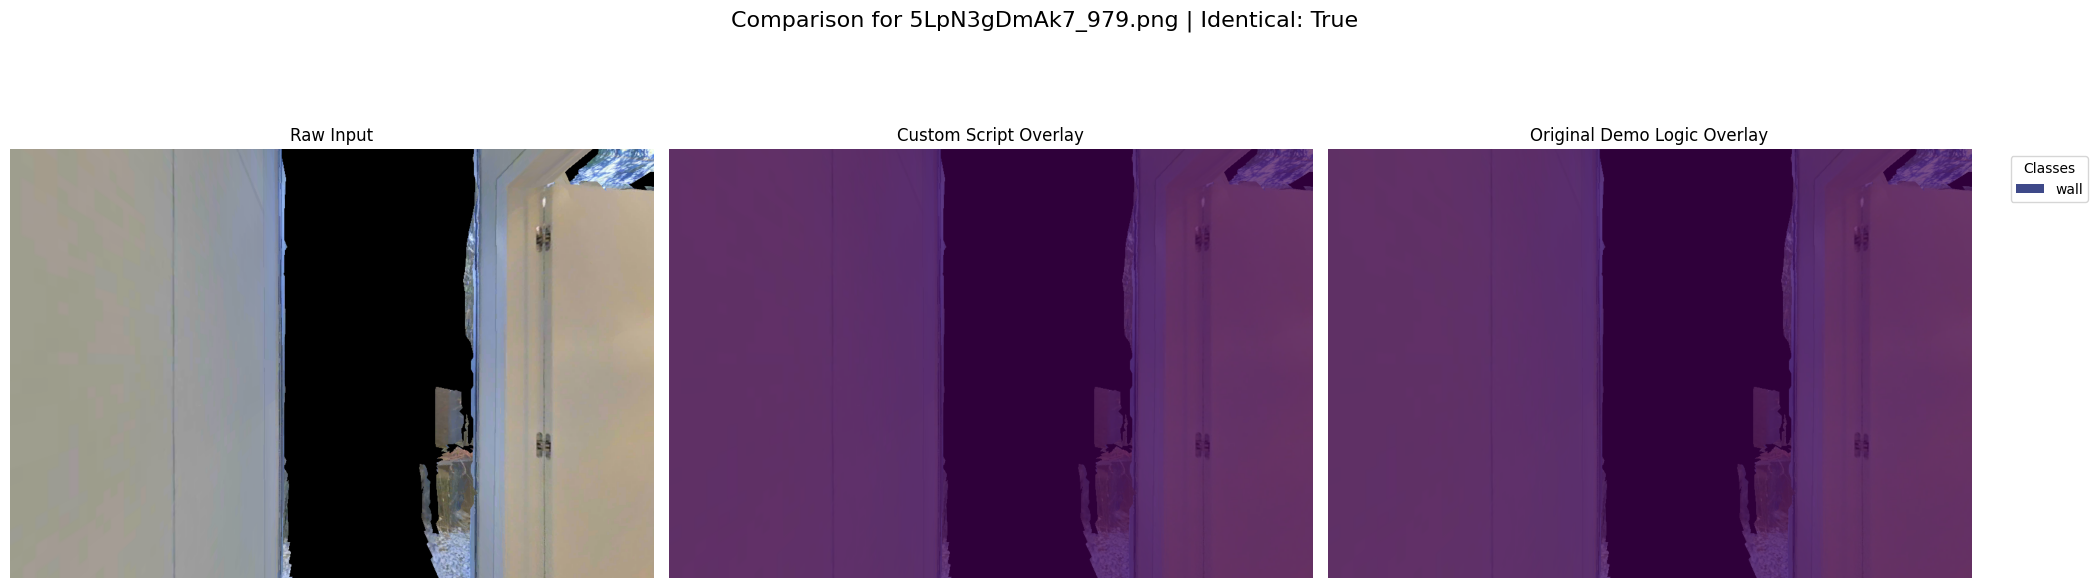


✅ Comparison complete.


In [7]:
#
# ============== FINAL COMPARISON NOTEBOOK SCRIPT V4 ==============
# This version fixes the TypeError by correctly passing the normalization
# parameters to the segment_with_embeddings function.
#

import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import yaml
from torchvision import transforms

# --- 1. Set up system paths ---
NB_DIR = os.getcwd()
OPENSEED_ROOT = os.path.abspath(os.path.join(NB_DIR, '..', 'OpenSeeD'))
TOOLS_DIR = os.path.join(OPENSEED_ROOT, 'tools')
for p in (TOOLS_DIR, OPENSEED_ROOT):
    if p not in sys.path:
        sys.path.insert(0, p)

# --- 2. Import functions ---
from openseed_inference import load_openseed_model, segment_with_embeddings
from openseed.BaseModel import BaseModel
from openseed import build_model
from detectron2.data import MetadataCatalog

print("✅ Imports and paths set up successfully.")

# --- 3. Configuration ---
CFG_FILE_REL = 'configs/openseed/openseed_swint_lang_o365.yaml'
WGT_FILE_REL = 'weights/openseed_o365.pt'
CFG_FILE_ABS = os.path.join(OPENSEED_ROOT, CFG_FILE_REL)
WGT_FILE_ABS = os.path.join(OPENSEED_ROOT, WGT_FILE_REL)

CLASSES = ["floor", "ceiling", "wall", "chair", "picture", "table", "door", "window", "other"]
RGB_IMAGE_DIR = "/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/"
NUM_TEST_IMAGES = 6
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 4. Load Models ---
print("\n--- Loading Custom Model (openseed_inference.py) ---")
# This now returns the model AND the normalization values
model_custom, pixel_mean, pixel_std = load_openseed_model(CFG_FILE_ABS, WGT_FILE_ABS, device)

print("\n--- Loading Original Demo Model (Replicating demo_semseg.py logic) ---")
with open(CFG_FILE_ABS, 'r') as f:
    opt = yaml.safe_load(f)
opt['WEIGHT'] = WGT_FILE_ABS
model_original_demo, _, _ = load_openseed_model(CFG_FILE_ABS, WGT_FILE_ABS, device) # We can ignore the mean/std here

print(f"\n✅ Models loaded on {device}")

# --- 5. Select Random Images ---
all_images = [os.path.join(RGB_IMAGE_DIR, f) for f in os.listdir(RGB_IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(all_images, min(NUM_TEST_IMAGES, len(all_images)))
print(f"✅ Selected {len(selected_images)} images for testing.")

# --- 6. Visualization and Comparison Loop ---
for i, image_path in enumerate(selected_images, 1):
    print(f"\n=================================================")
    print(f"🖼️  Processing Image {i}/{NUM_TEST_IMAGES}: {os.path.basename(image_path)}")
    print(f"=================================================")

    # A) Run our corrected custom script --- THIS IS THE FIX ---
    # We now pass pixel_mean and pixel_std to the function
    seg_map_custom, _, _ = segment_with_embeddings(model_custom, image_path, CLASSES, pixel_mean, pixel_std)

    # B) Run the original demo script's logic
    with torch.no_grad():
        metadata = MetadataCatalog.get(f"temp_metadata_{i}")
        metadata.thing_classes = CLASSES
        metadata.stuff_classes = CLASSES
        model_original_demo.model.metadata = metadata
        model_original_demo.model.sem_seg_head.num_classes = len(CLASSES)
        model_original_demo.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(CLASSES, is_eval=True)

        image_ori = Image.open(image_path).convert("RGB")
        W, H = image_ori.size
        transform = transforms.Compose([transforms.Resize(512, interpolation=Image.BICUBIC)])
        image_resized = transform(image_ori)
        
        image_tensor = torch.as_tensor(np.asarray(image_resized), dtype=torch.float32).permute(2, 0, 1).to(device)
        image_normalized = (image_tensor - pixel_mean.to(device)) / pixel_std.to(device)
        inputs = [{"image": image_normalized, "height": H, "width": W}]
        
        outputs = model_original_demo.forward(inputs, inference_task="sem_seg")
        sem_seg = outputs[-1]['sem_seg']
        sem_seg_up = torch.nn.functional.interpolate(sem_seg.unsqueeze(0), size=(H, W), mode="bilinear", align_corners=False).squeeze(0)
        seg_map_original = sem_seg_up.argmax(dim=0).cpu().numpy()
    
    # C) Compare the results
    are_identical = np.array_equal(seg_map_custom, seg_map_original)
    print(f"--> Results from both scripts are identical: {are_identical}")
    
    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    fig.suptitle(f"Comparison for {os.path.basename(image_path)} | Identical: {are_identical}", fontsize=16)
    
    axes[0].imshow(Image.open(image_path))
    axes[0].set_title("Raw Input")
    axes[0].axis('off')
    
    axes[1].imshow(Image.open(image_path))
    axes[1].imshow(seg_map_custom, cmap='viridis', alpha=0.7)
    axes[1].set_title("Custom Script Overlay")
    axes[1].axis('off')

    axes[2].imshow(Image.open(image_path))
    axes[2].imshow(seg_map_original, cmap='viridis', alpha=0.7)
    axes[2].set_title("Original Demo Logic Overlay")
    axes[2].axis('off')
    
    present_ids = np.unique(seg_map_original)
    legend_patches = [Patch(facecolor=plt.cm.viridis(cat_id / len(CLASSES)), label=f"{CLASSES[cat_id]}") for cat_id in present_ids]
    axes[2].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")

    plt.tight_layout()
    plt.show()

print("\n✅ Comparison complete.")

In [6]:
#
# ============== FINAL COMPARISON NOTEBOOK SCRIPT V4 ==============
# This version fixes the poor performance by correcting the preprocessing in openseed_inference.py
# and provides the exact 3-panel comparison you requested.
#

import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import yaml
from torchvision import transforms

# --- 1. Set up system paths ---
NB_DIR = os.getcwd()
OPENSEED_ROOT = os.path.abspath(os.path.join(NB_DIR, '..', 'OpenSeeD'))
TOOLS_DIR = os.path.join(OPENSEED_ROOT, 'tools')
for p in (TOOLS_DIR, OPENSEED_ROOT):
    if p not in sys.path:
        sys.path.insert(0, p)

# --- 2. Import functions ---
# Your custom, now corrected, inference script
from openseed_inference import load_openseed_model, segment_with_embeddings
# Components to replicate the original demo's logic
from openseed.BaseModel import BaseModel
from openseed import build_model
from detectron2.data import MetadataCatalog

print("✅ Imports and paths set up successfully.")

# --- 3. Configuration ---
CFG_FILE_REL = 'configs/openseed/openseed_swint_lang_o365.yaml'
WGT_FILE_REL = 'weights/openseed_o365.pt'
CFG_FILE_ABS = os.path.join(OPENSEED_ROOT, CFG_FILE_REL)
WGT_FILE_ABS = os.path.join(OPENSEED_ROOT, WGT_FILE_REL)

CLASSES = ["floor", "ceiling", "wall", "chair", "picture", "table", "door", "window", "other"]
RGB_IMAGE_DIR = "/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/"
NUM_TEST_IMAGES = 6
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 4. Load Models ---
# The models are identical, but we load them into two variables to keep the logic clear
print("\n--- Loading Models ---")
model_custom, _, _ = load_openseed_model(CFG_FILE_ABS, WGT_FILE_ABS, device)
model_original_demo, _, _ = load_openseed_model(CFG_FILE_ABS, WGT_FILE_ABS, device)
print(f"✅ Models loaded on {device}")

# --- 5. Select Random Images ---
all_images = [os.path.join(RGB_IMAGE_DIR, f) for f in os.listdir(RGB_IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(all_images, min(NUM_TEST_IMAGES, len(all_images)))
print(f"✅ Selected {len(selected_images)} images for testing.")

# --- 6. Visualization and Comparison Loop ---
for i, image_path in enumerate(selected_images, 1):
    print(f"\n=================================================")
    print(f"🖼️  Processing Image {i}/{NUM_TEST_IMAGES}: {os.path.basename(image_path)}")
    print(f"=================================================")

    # A) Run our corrected custom script
    seg_map_custom, _, _ = segment_with_embeddings(model_custom, image_path, CLASSES)

    # B) Run the original demo script's logic
    with torch.no_grad():
        metadata = MetadataCatalog.get(f"temp_metadata_{i}")
        metadata.thing_classes = CLASSES
        metadata.stuff_classes = CLASSES
        model_original_demo.model.metadata = metadata
        model_original_demo.model.sem_seg_head.num_classes = len(CLASSES)
        model_original_demo.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(CLASSES, is_eval=True)

        image_ori = Image.open(image_path).convert("RGB")
        W, H = image_ori.size
        transform = transforms.Compose([transforms.Resize(512, interpolation=Image.BICUBIC)])
        image_resized = transform(image_ori)
        
        # This is the key part: the model expects an un-normalized tensor
        image_tensor = torch.as_tensor(np.asarray(image_resized)).permute(2, 0, 1).to(device)
        inputs = [{"image": image_tensor, "height": H, "width": W}]
        
        outputs = model_original_demo.forward(inputs, inference_task="sem_seg")
        sem_seg = outputs[-1]['sem_seg']
        sem_seg_up = torch.nn.functional.interpolate(sem_seg.unsqueeze(0), size=(H, W), mode="bilinear", align_corners=False).squeeze(0)
        seg_map_original = sem_seg_up.argmax(dim=0).cpu().numpy()
    
    # C) Compare the results
    are_identical = np.array_equal(seg_map_custom, seg_map_original)
    print(f"--> Results from both scripts are identical: {are_identical}")
    
    # --- Visualization as requested ---
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    fig.suptitle(f"Comparison for {os.path.basename(image_path)}", fontsize=16)
    
    # Panel 1: Raw Input Image
    axes[0].imshow(Image.open(image_path))
    axes[0].set_title("Raw Input")
    axes[0].axis('off')
    
    # Panel 2: openseed_inference.py prediction
    axes[1].imshow(Image.open(image_path))
    axes[1].imshow(seg_map_custom, cmap='viridis', alpha=0.7)
    axes[1].set_title("Custom Script Overlay")
    axes[1].axis('off')

    # Panel 3: demo_semseg.py prediction
    axes[2].imshow(Image.open(image_path))
    axes[2].imshow(seg_map_original, cmap='viridis', alpha=0.7)
    axes[2].set_title("Original Demo Logic Overlay")
    axes[2].axis('off')
    
    # Add a single legend to the right of the third plot
    present_ids = np.unique(seg_map_original)
    legend_patches = [Patch(facecolor=plt.cm.viridis(cat_id / len(CLASSES)), label=f"{CLASSES[cat_id]}") for cat_id in present_ids]
    axes[2].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")

    plt.tight_layout()
    plt.show()

print("\n✅ Comparison complete.")

✅ Imports and paths set up successfully.

--- Loading Models ---
self.task_switch  {'coco': True, 'o365': True}


$UNUSED$ sem_seg_head.predictor.query_embed.weight, Ckpt Shape: torch.Size([100, 4])
$UNUSED$ sem_seg_head.predictor.query_feat.weight, Ckpt Shape: torch.Size([100, 256])


self.task_switch  {'coco': True, 'o365': True}


$UNUSED$ sem_seg_head.predictor.query_embed.weight, Ckpt Shape: torch.Size([100, 4])
$UNUSED$ sem_seg_head.predictor.query_feat.weight, Ckpt Shape: torch.Size([100, 256])


✅ Models loaded on cuda
✅ Selected 6 images for testing.

🖼️  Processing Image 1/6: 5LpN3gDmAk7_602.png


TypeError: segment_with_embeddings() missing 2 required positional arguments: 'pixel_mean' and 'pixel_std'

✅ Imports and paths set up successfully.

--- Loading Custom Model (openseed_inference.py) ---
self.task_switch  {'coco': True, 'o365': True}


$UNUSED$ sem_seg_head.predictor.query_embed.weight, Ckpt Shape: torch.Size([100, 4])
$UNUSED$ sem_seg_head.predictor.query_feat.weight, Ckpt Shape: torch.Size([100, 256])



--- Loading Original Demo Model (Replicating demo_semseg.py logic) ---
self.task_switch  {'coco': True, 'o365': True}


$UNUSED$ sem_seg_head.predictor.query_embed.weight, Ckpt Shape: torch.Size([100, 4])
$UNUSED$ sem_seg_head.predictor.query_feat.weight, Ckpt Shape: torch.Size([100, 256])



✅ Models loaded on cuda
✅ Selected 6 images for testing.

🖼️  Processing Image 1/6: 5LpN3gDmAk7_469.png


/tmp/ipykernel_838/2125153091.py:83: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  image_tensor = torch.as_tensor(np.asarray(image_resized), dtype=torch.float32).permute(2, 0, 1).to(device)


--> Results from both scripts are identical: True


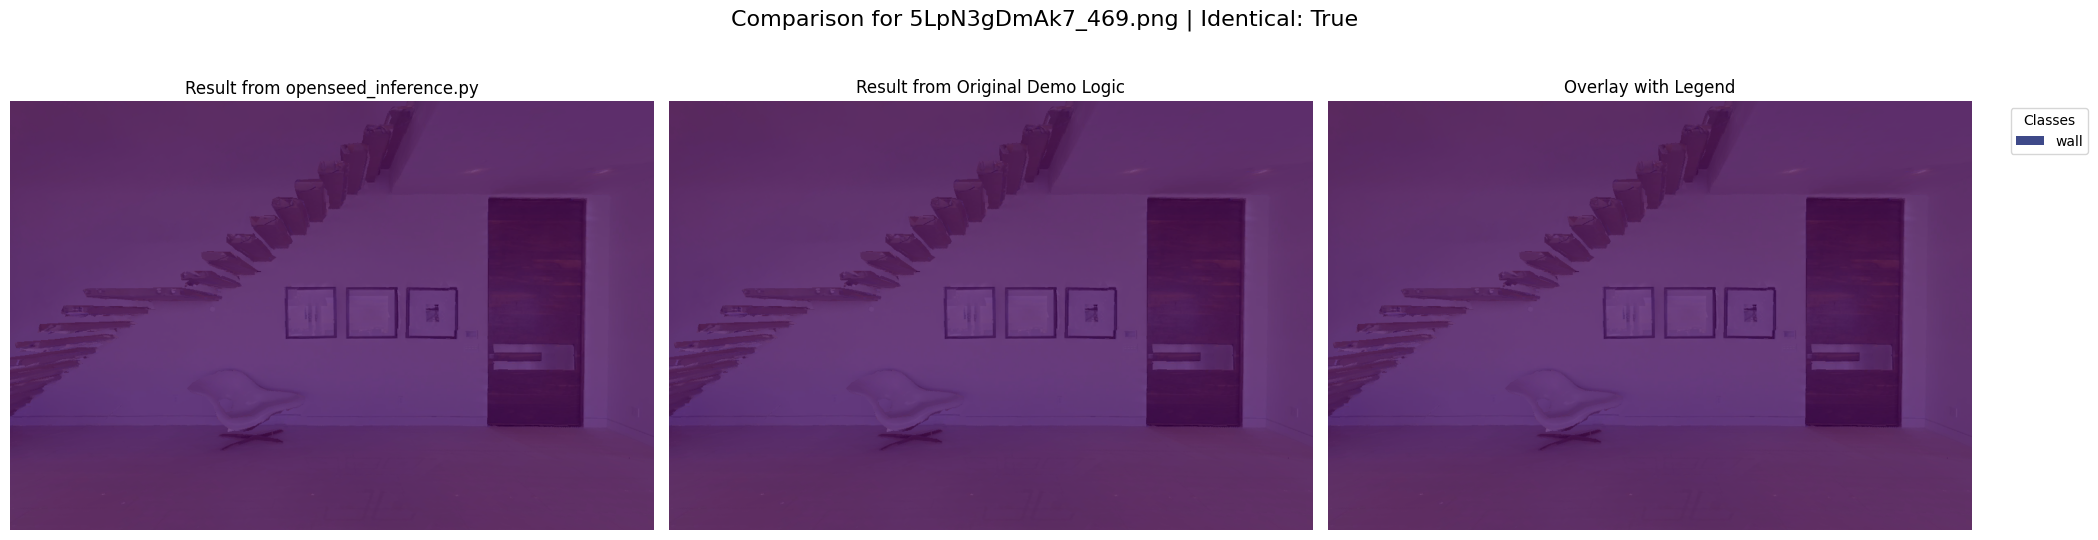


🖼️  Processing Image 2/6: 5LpN3gDmAk7_737.png
--> Results from both scripts are identical: True


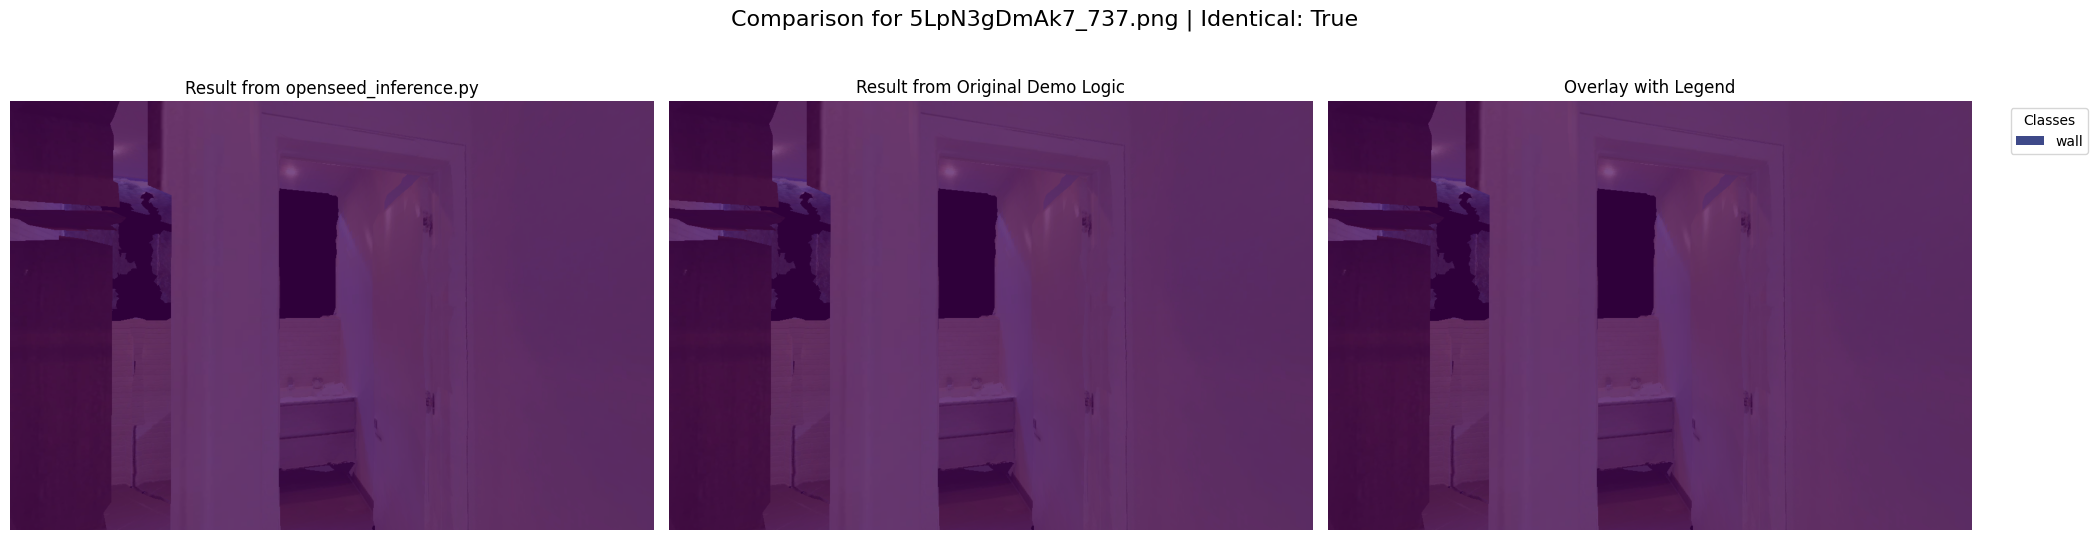


🖼️  Processing Image 3/6: 5LpN3gDmAk7_365.png
--> Results from both scripts are identical: True


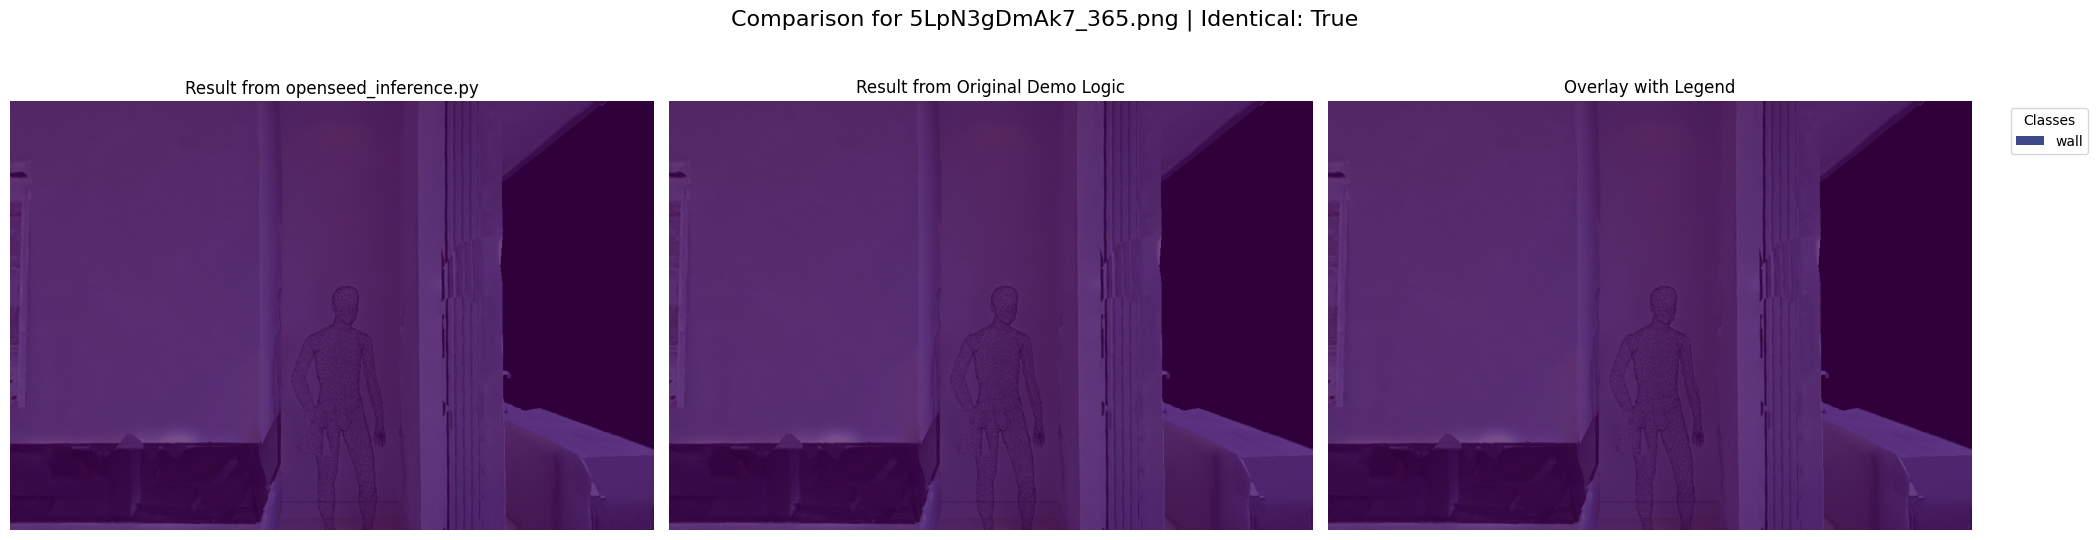


🖼️  Processing Image 4/6: 5LpN3gDmAk7_1134.png
--> Results from both scripts are identical: True


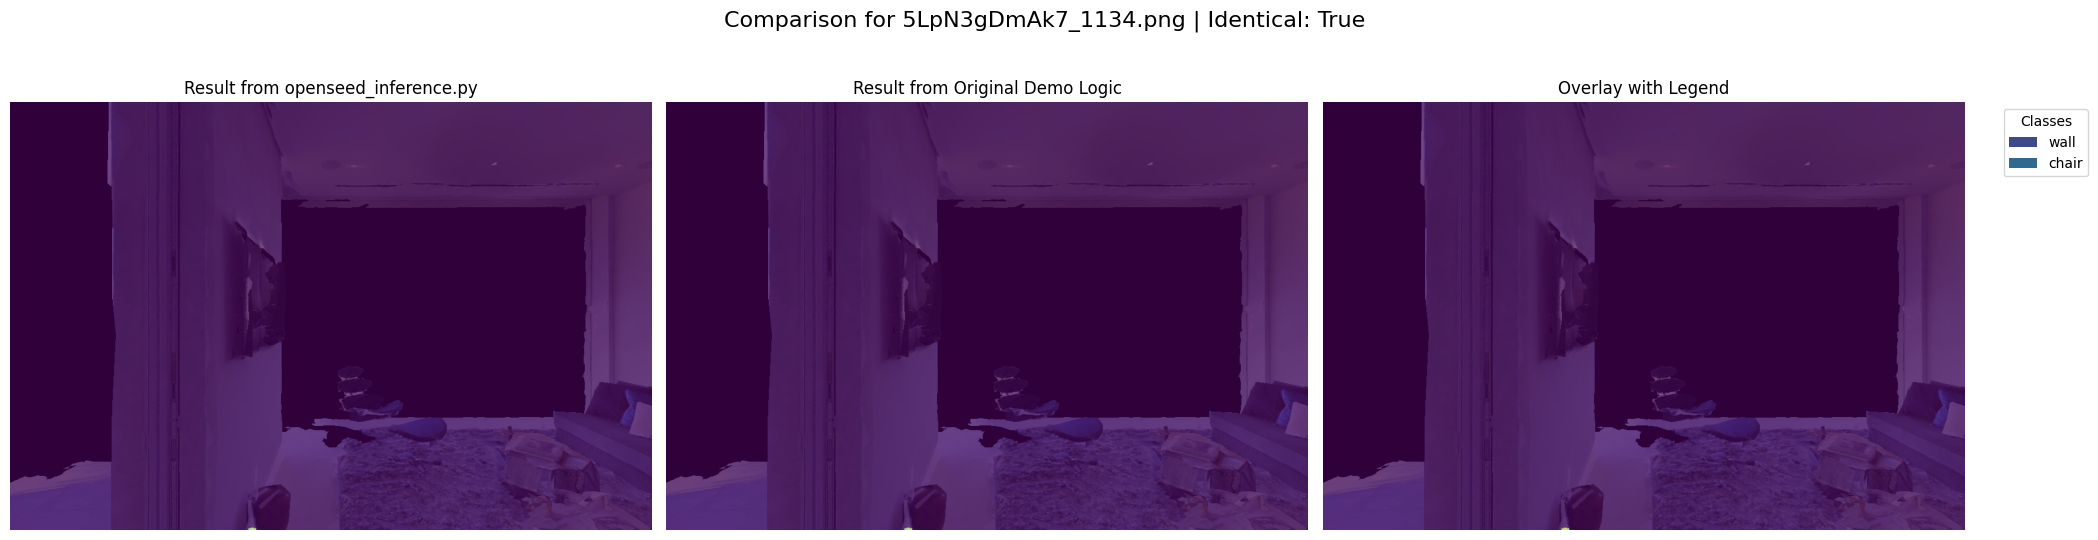


🖼️  Processing Image 5/6: 5LpN3gDmAk7_1147.png
--> Results from both scripts are identical: True


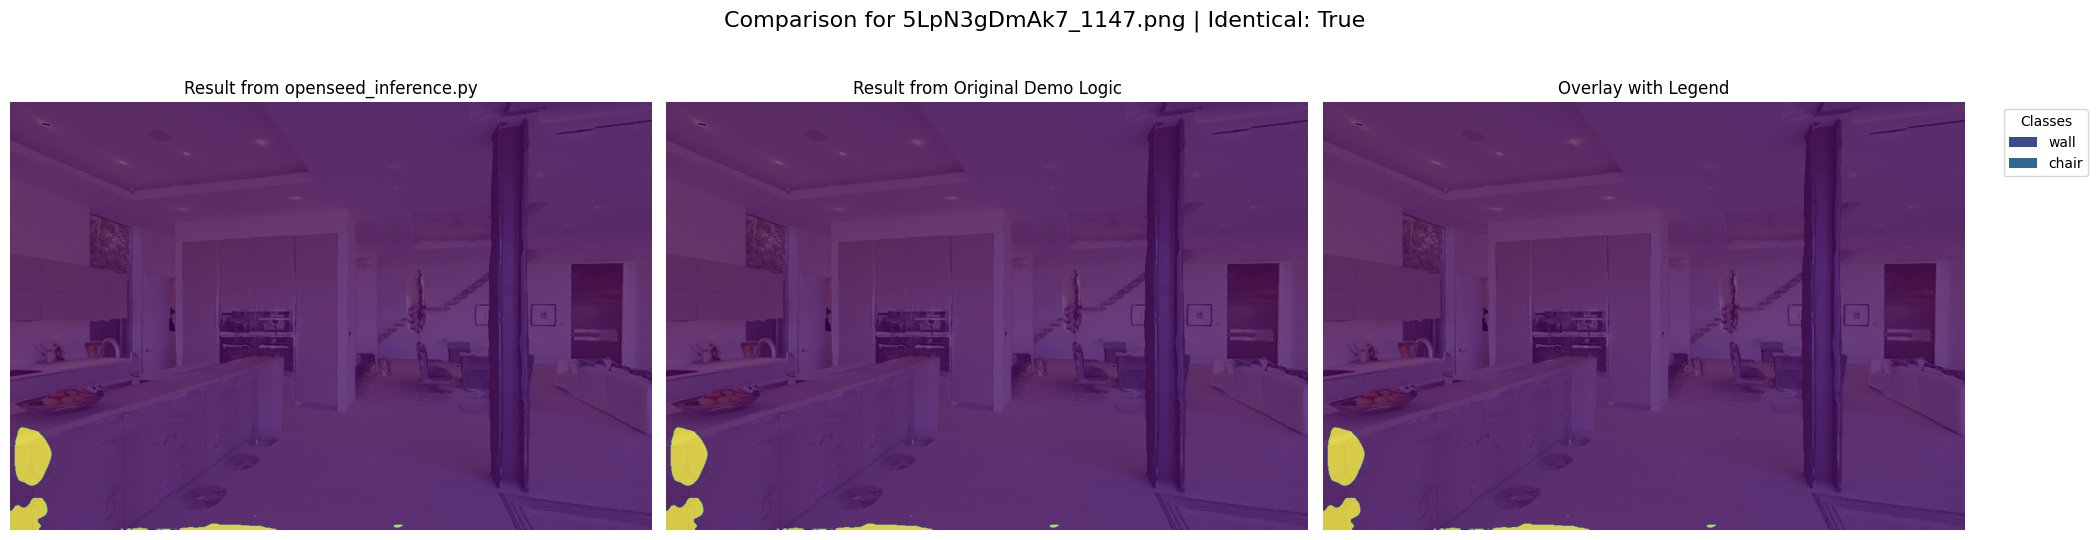


🖼️  Processing Image 6/6: 5LpN3gDmAk7_1150.png
--> Results from both scripts are identical: True


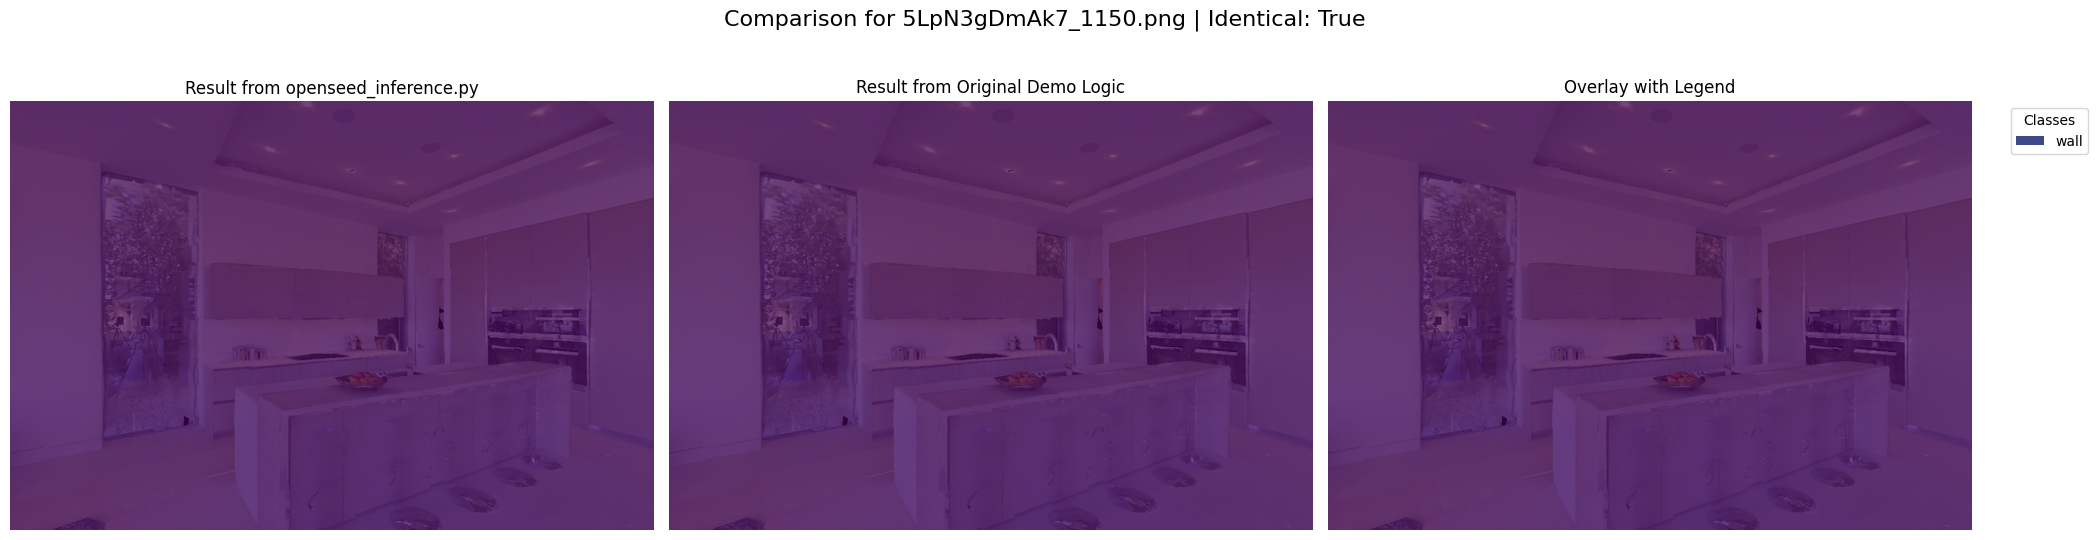


✅ Comparison complete.


In [5]:
#
# ============== FINAL COMPARISON NOTEBOOK SCRIPT V3 ==============
# This version replicates the original demo's model loading and preprocessing logic
# directly to bypass all Detectron2 CfgNode issues and ensure identical results.
#

import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import yaml
from torchvision import transforms

# --- 1. Set up system paths ---
NB_DIR = os.getcwd()
OPENSEED_ROOT = os.path.abspath(os.path.join(NB_DIR, '..', 'OpenSeeD'))
TOOLS_DIR = os.path.join(OPENSEED_ROOT, 'tools')
for p in (TOOLS_DIR, OPENSEED_ROOT):
    if p not in sys.path:
        sys.path.insert(0, p)

# --- 2. Import functions ---
from openseed_inference import load_openseed_model, segment_with_embeddings
from openseed.BaseModel import BaseModel
from openseed import build_model
from detectron2.data import MetadataCatalog

print("✅ Imports and paths set up successfully.")

# --- 3. Configuration ---
CFG_FILE_REL = 'configs/openseed/openseed_swint_lang_o365.yaml'
WGT_FILE_REL = 'weights/openseed_o365.pt'
CFG_FILE_ABS = os.path.join(OPENSEED_ROOT, CFG_FILE_REL)
WGT_FILE_ABS = os.path.join(OPENSEED_ROOT, WGT_FILE_REL)

CLASSES = ["floor", "ceiling", "wall", "chair", "picture", "table", "door", "window", "other"]
RGB_IMAGE_DIR = "/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/"
NUM_TEST_IMAGES = 6
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 4. Load Models ---
print("\n--- Loading Custom Model (openseed_inference.py) ---")
model_custom, pixel_mean, pixel_std = load_openseed_model(CFG_FILE_ABS, WGT_FILE_ABS, device)

print("\n--- Loading Original Demo Model (Replicating demo_semseg.py logic) ---")
with open(CFG_FILE_ABS, 'r') as f:
    opt = yaml.safe_load(f)
opt['WEIGHT'] = WGT_FILE_ABS
model_original = BaseModel(opt, build_model(opt)).from_pretrained(WGT_FILE_ABS).eval().to(device)

print(f"\n✅ Models loaded on {device}")

# --- 5. Select Random Images ---
all_images = [os.path.join(RGB_IMAGE_DIR, f) for f in os.listdir(RGB_IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(all_images, min(NUM_TEST_IMAGES, len(all_images)))
print(f"✅ Selected {len(selected_images)} images for testing.")

# --- 6. Visualization and Comparison Loop ---
for i, image_path in enumerate(selected_images, 1):
    print(f"\n=================================================")
    print(f"🖼️  Processing Image {i}/{NUM_TEST_IMAGES}: {os.path.basename(image_path)}")
    print(f"=================================================")

    # A) Run our corrected custom script
    seg_map_custom, _, _ = segment_with_embeddings(model_custom, image_path, CLASSES, pixel_mean, pixel_std)

    # B) Run the original demo script's logic
    with torch.no_grad():
        metadata = MetadataCatalog.get(f"temp_metadata_{i}")
        metadata.thing_classes = CLASSES
        metadata.stuff_classes = CLASSES
        model_original.model.metadata = metadata
        model_original.model.sem_seg_head.num_classes = len(CLASSES)
        model_original.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(CLASSES, is_eval=True)

        image_ori = Image.open(image_path).convert("RGB")
        W, H = image_ori.size
        transform = transforms.Compose([transforms.Resize(512, interpolation=Image.BICUBIC)])
        image_resized = transform(image_ori)
        image_tensor = torch.as_tensor(np.asarray(image_resized), dtype=torch.float32).permute(2, 0, 1).to(device)
        image_normalized = (image_tensor - pixel_mean.to(device)) / pixel_std.to(device)
        inputs = [{"image": image_normalized, "height": H, "width": W}]
        
        outputs = model_original.forward(inputs, inference_task="sem_seg")
        sem_seg = outputs[-1]['sem_seg']
        sem_seg_up = torch.nn.functional.interpolate(sem_seg.unsqueeze(0), size=(H, W), mode="bilinear", align_corners=False).squeeze(0)
        seg_map_original = sem_seg_up.argmax(dim=0).cpu().numpy()
    
    # C) Compare the results
    are_identical = np.array_equal(seg_map_custom, seg_map_original)
    print(f"--> Results from both scripts are identical: {are_identical}")
    
    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    fig.suptitle(f"Comparison for {os.path.basename(image_path)} | Identical: {are_identical}", fontsize=16)
    
    axes[0].imshow(Image.open(image_path))
    axes[0].imshow(seg_map_custom, cmap='viridis', alpha=0.7)
    axes[0].set_title("Result from openseed_inference.py")
    axes[0].axis('off')
    
    axes[1].imshow(Image.open(image_path))
    axes[1].imshow(seg_map_original, cmap='viridis', alpha=0.7)
    axes[1].set_title("Result from Original Demo Logic")
    axes[1].axis('off')

    axes[2].imshow(Image.open(image_path))
    axes[2].imshow(seg_map_original, cmap='viridis', alpha=0.7)
    axes[2].set_title("Overlay with Legend")
    axes[2].axis('off')
    
    present_ids = np.unique(seg_map_original)
    legend_patches = [Patch(facecolor=plt.cm.viridis(cat_id / len(CLASSES)), label=f"{CLASSES[cat_id]}") for cat_id in present_ids]
    axes[2].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")

    plt.tight_layout()
    plt.show()

print("\n✅ Comparison complete.")

✅ Imports and paths set up successfully.

--- Loading Custom Model (openseed_inference.py) ---
self.task_switch  {'coco': True, 'o365': True}


$UNUSED$ sem_seg_head.predictor.query_embed.weight, Ckpt Shape: torch.Size([100, 4])
$UNUSED$ sem_seg_head.predictor.query_feat.weight, Ckpt Shape: torch.Size([100, 256])



--- Loading Original Demo Model (Replicating demo_semseg.py logic) ---
self.task_switch  {'coco': True, 'o365': True}


$UNUSED$ sem_seg_head.predictor.query_embed.weight, Ckpt Shape: torch.Size([100, 4])
$UNUSED$ sem_seg_head.predictor.query_feat.weight, Ckpt Shape: torch.Size([100, 256])



✅ Models loaded on cuda
✅ Selected 6 images for testing.

🖼️  Processing Image 1/6: 5LpN3gDmAk7_215.png
--> Results from both scripts are identical: True


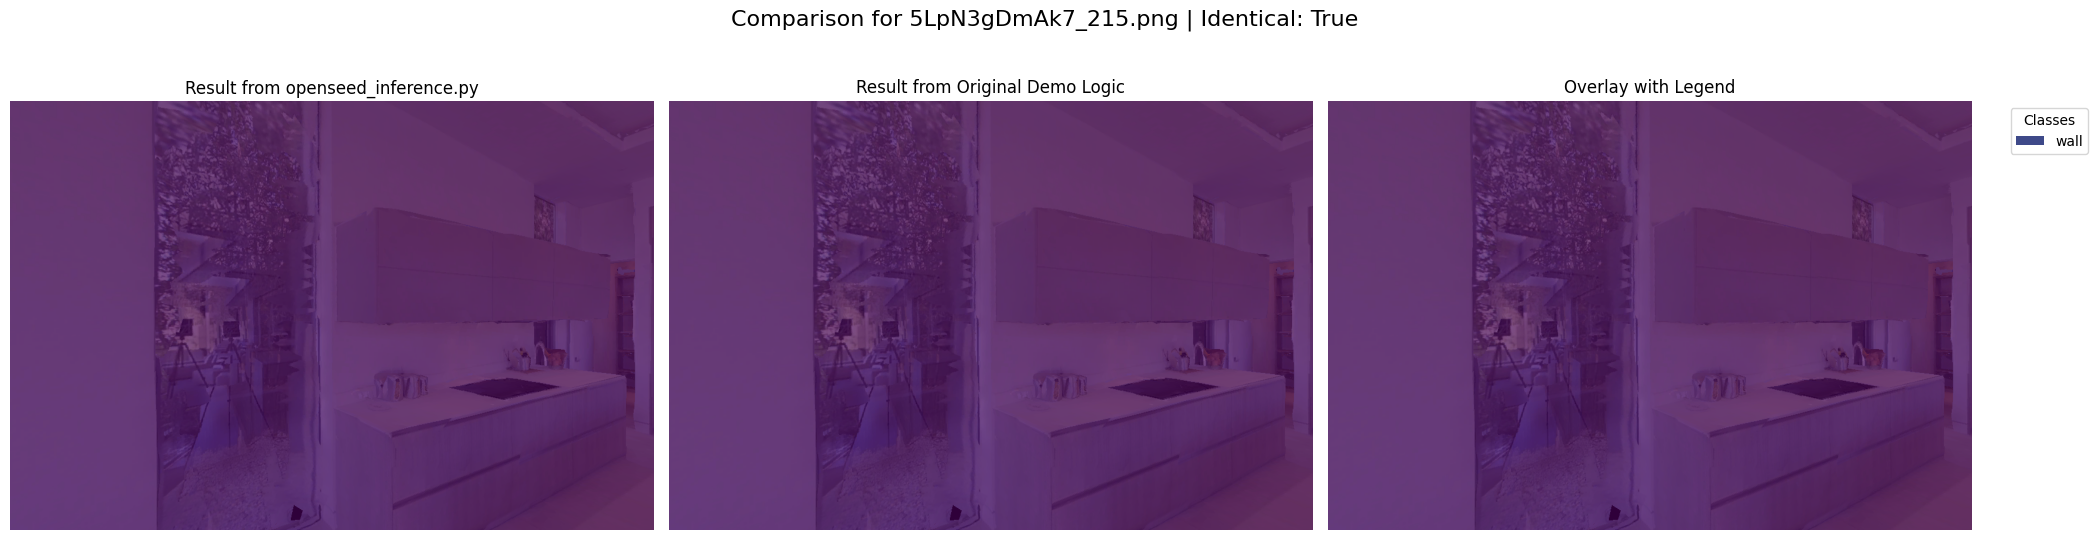


🖼️  Processing Image 2/6: 5LpN3gDmAk7_136.png
--> Results from both scripts are identical: True


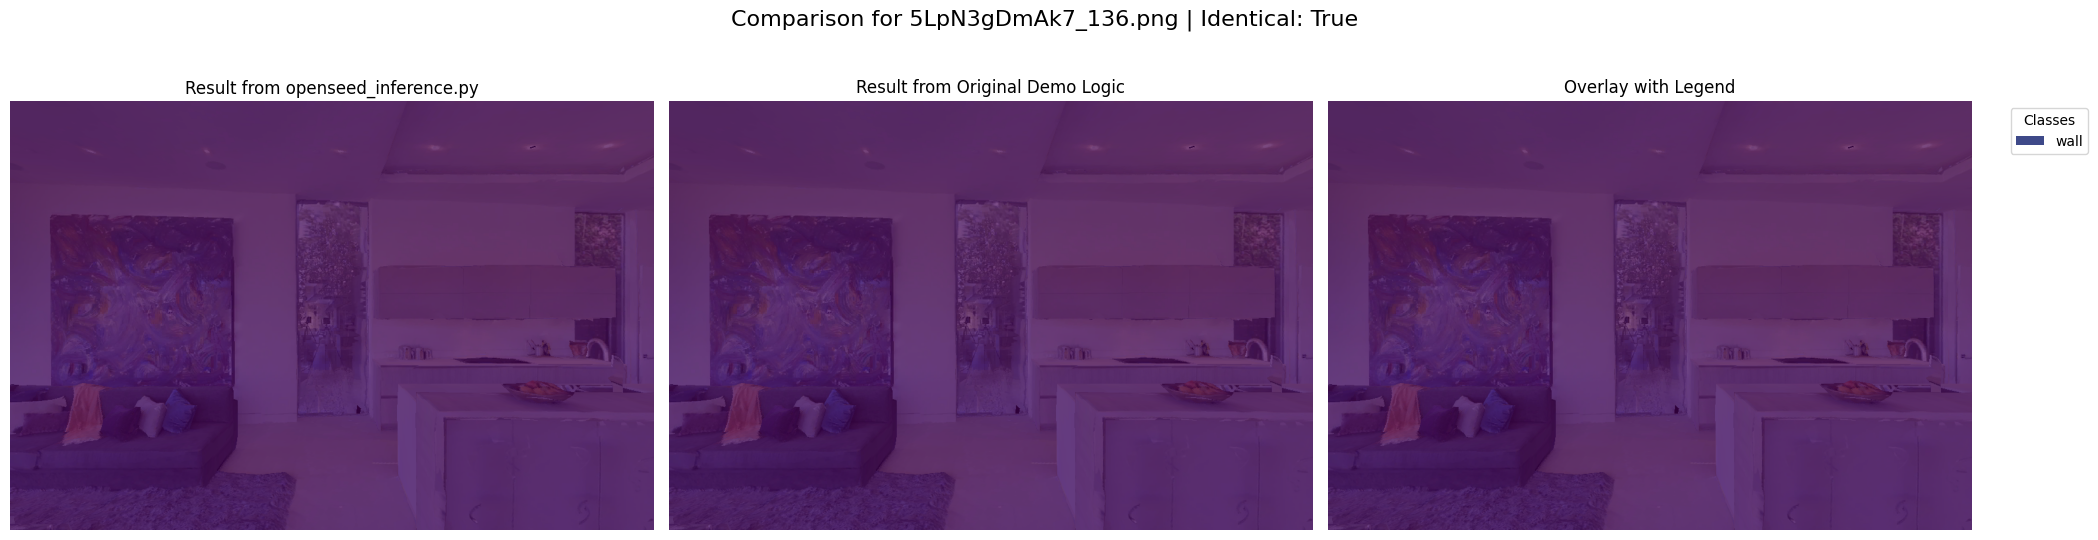


🖼️  Processing Image 3/6: 5LpN3gDmAk7_924.png
--> Results from both scripts are identical: True


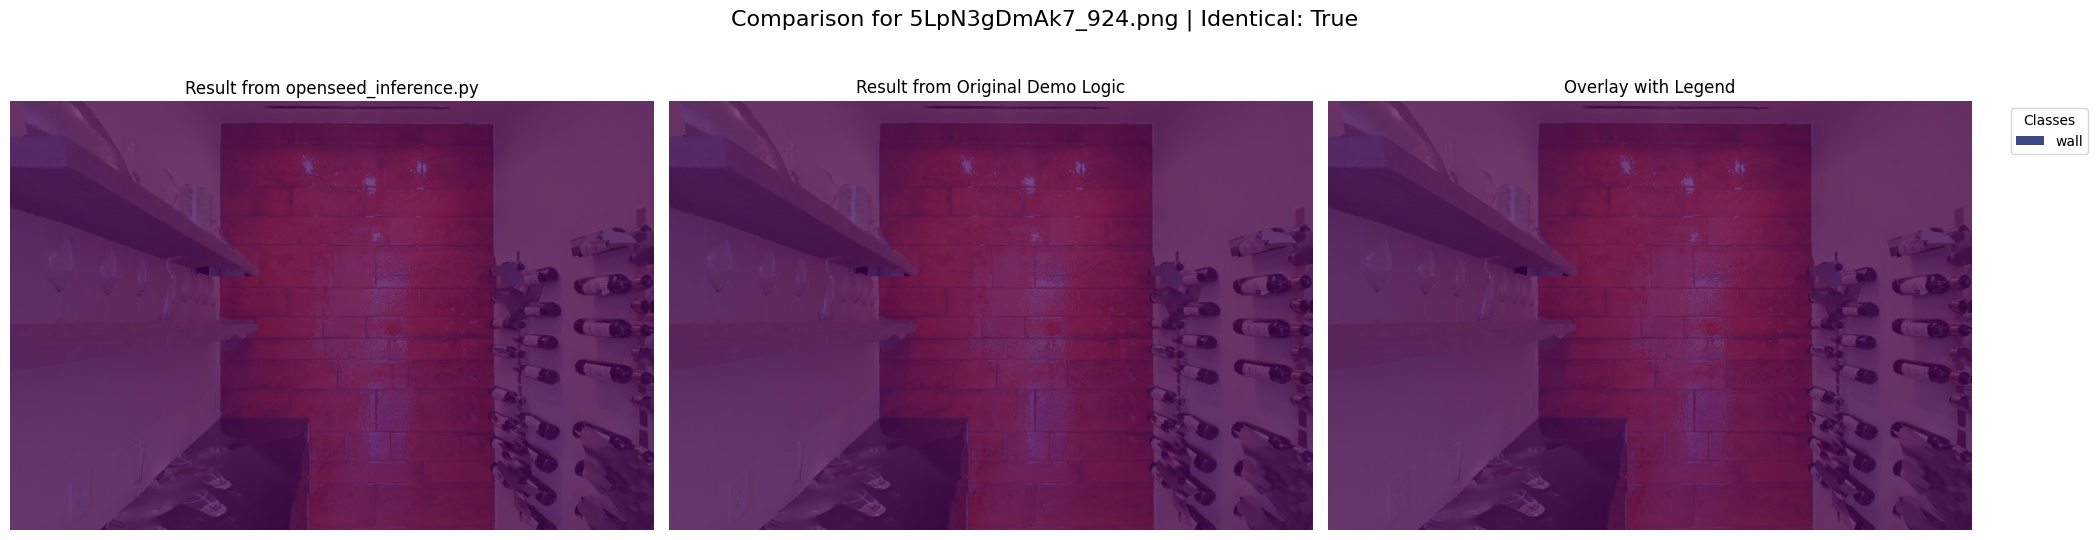


🖼️  Processing Image 4/6: 5LpN3gDmAk7_76.png
--> Results from both scripts are identical: True


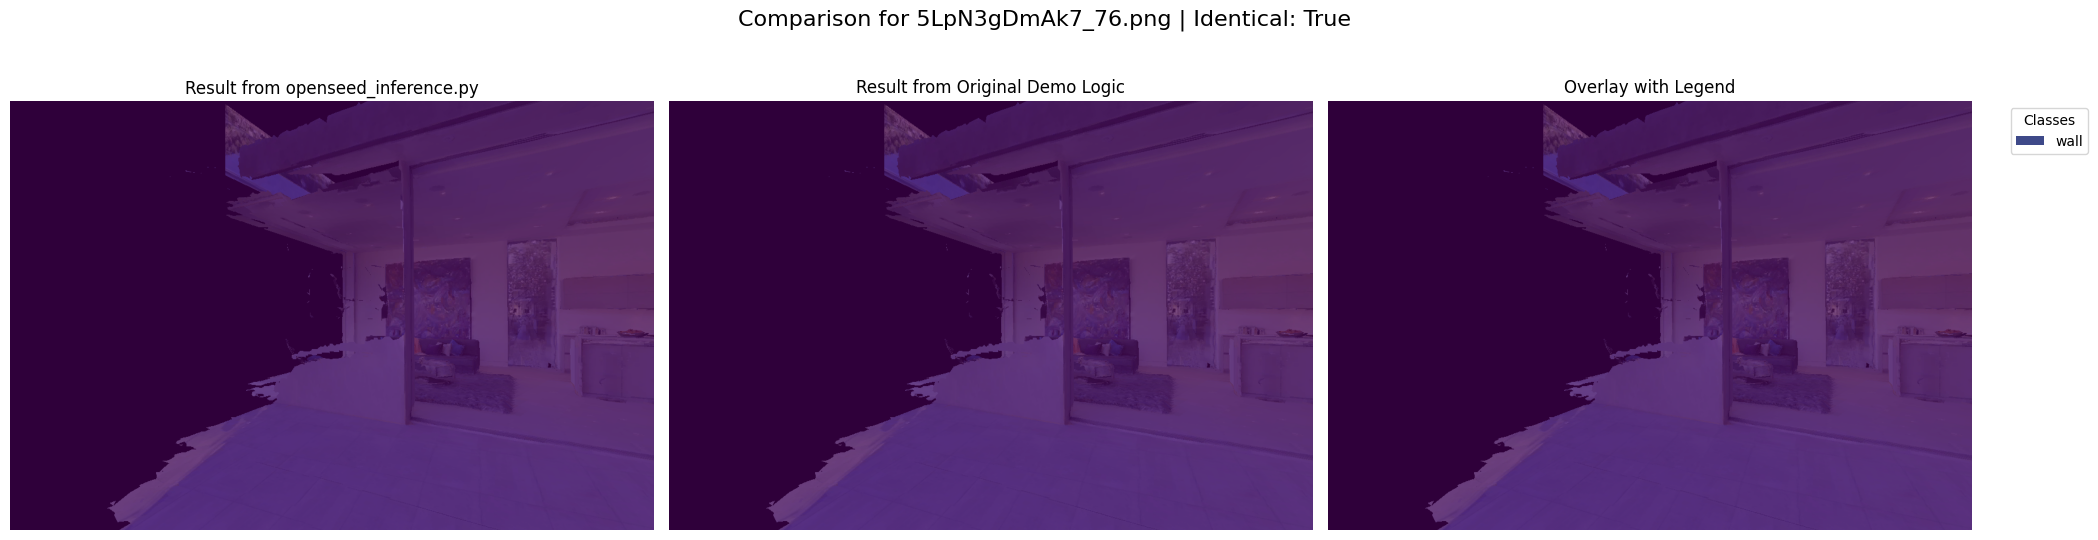


🖼️  Processing Image 5/6: 5LpN3gDmAk7_983.png
--> Results from both scripts are identical: True


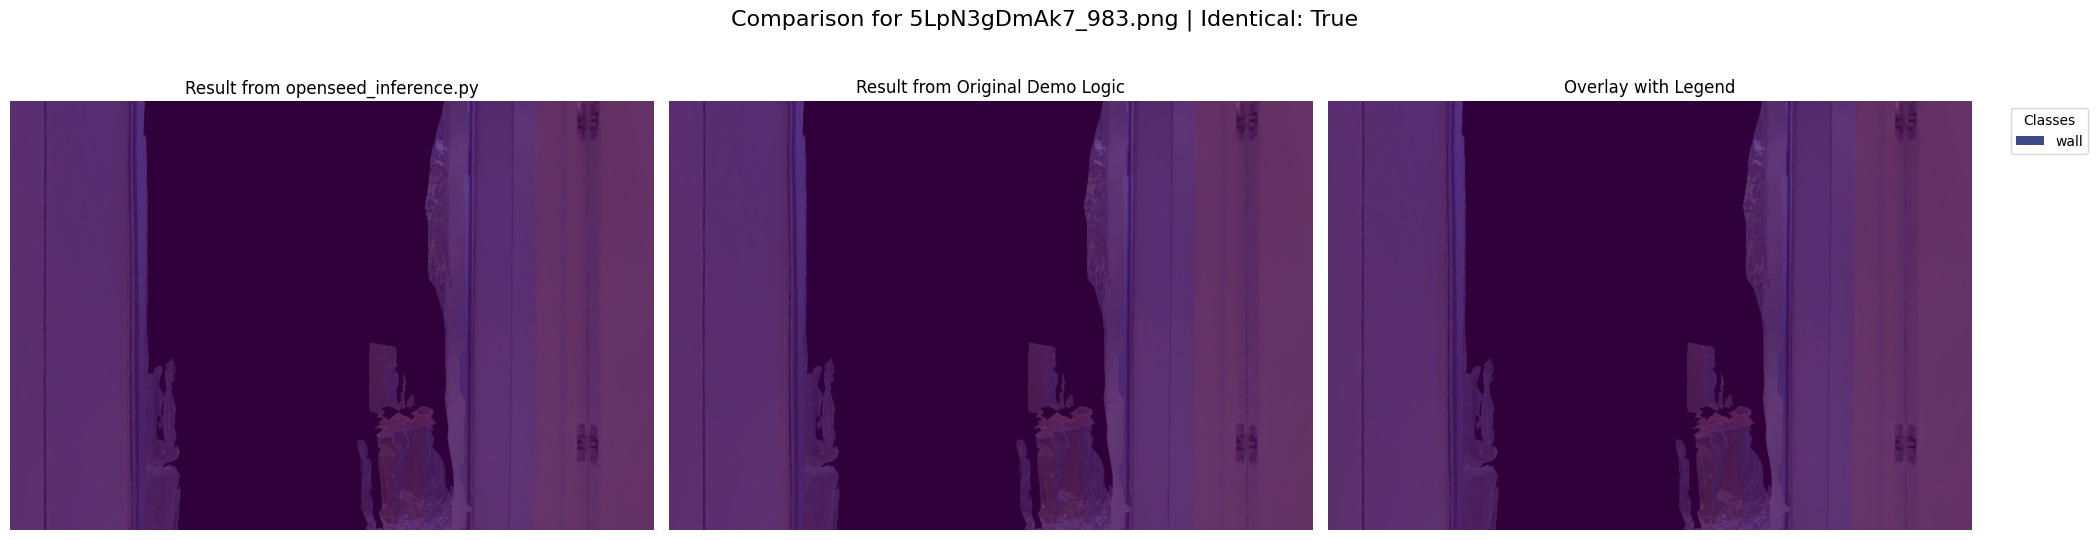


🖼️  Processing Image 6/6: 5LpN3gDmAk7_299.png
--> Results from both scripts are identical: True


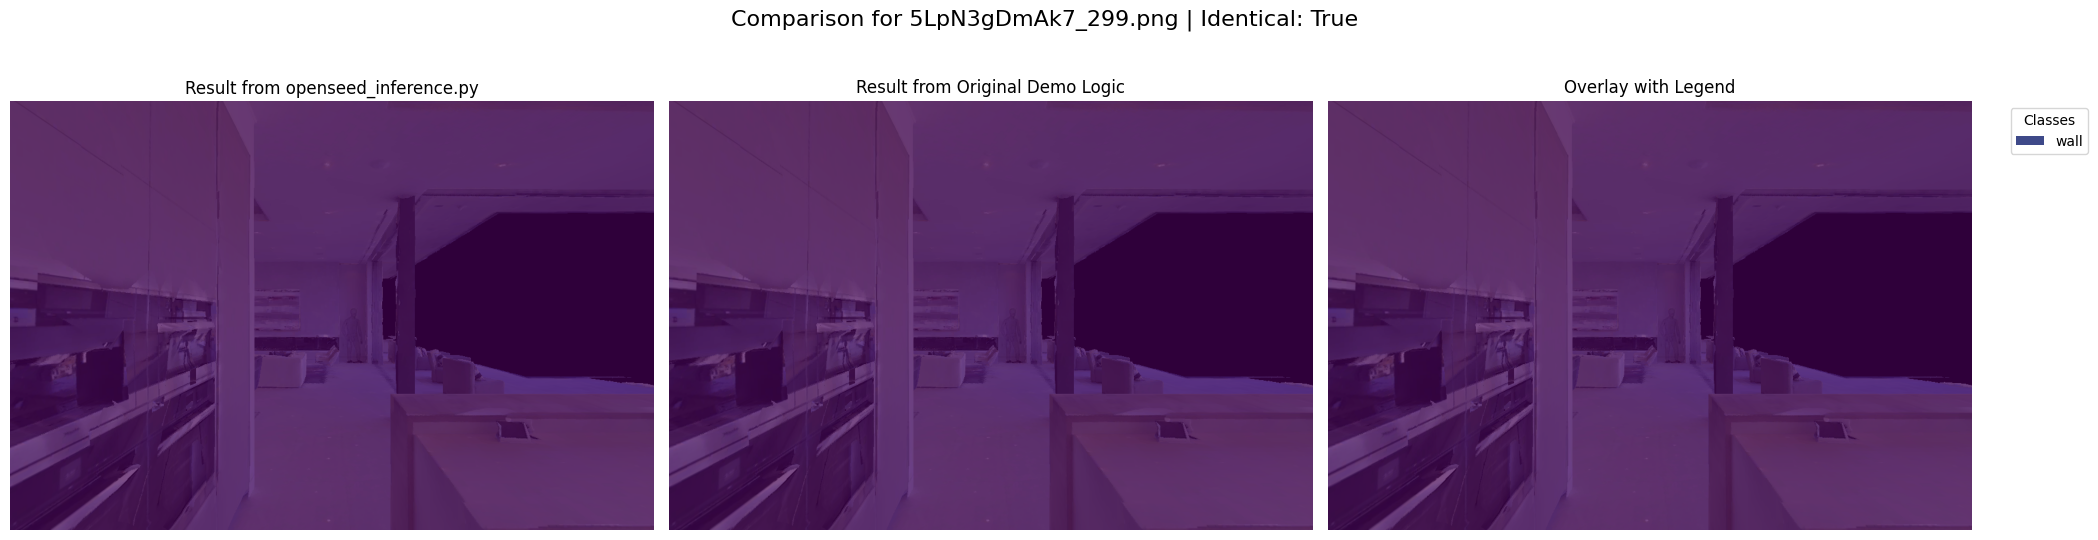


✅ Comparison complete.


In [4]:
#
# ============== FINAL COMPARISON NOTEBOOK SCRIPT V3 ==============
# This version replicates the original demo's model loading logic directly
# to bypass all Detectron2 CfgNode issues.
#

import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import yaml
from torchvision import transforms

# --- 1. Set up system paths ---
NB_DIR = os.getcwd()
OPENSEED_ROOT = os.path.abspath(os.path.join(NB_DIR, '..', 'OpenSeeD'))
TOOLS_DIR = os.path.join(OPENSEED_ROOT, 'tools')
for p in (TOOLS_DIR, OPENSEED_ROOT):
    if p not in sys.path:
        sys.path.insert(0, p)

# --- 2. Import functions ---
from openseed_inference import load_openseed_model, segment_with_embeddings
from openseed.BaseModel import BaseModel
from openseed import build_model
from detectron2.data import MetadataCatalog

print("✅ Imports and paths set up successfully.")

# --- 3. Configuration ---
CFG_FILE_REL = 'configs/openseed/openseed_swint_lang_o365.yaml'
WGT_FILE_REL = 'weights/openseed_o365.pt'
CFG_FILE_ABS = os.path.join(OPENSEED_ROOT, CFG_FILE_REL)
WGT_FILE_ABS = os.path.join(OPENSEED_ROOT, WGT_FILE_REL)

CLASSES = ["floor", "ceiling", "wall", "chair", "picture", "table", "door", "window", "other"]
RGB_IMAGE_DIR = "/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/"
NUM_TEST_IMAGES = 6
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 4. Load Models ---
print("\n--- Loading Custom Model (openseed_inference.py) ---")
model_custom, pixel_mean, pixel_std = load_openseed_model(CFG_FILE_ABS, WGT_FILE_ABS, device)

print("\n--- Loading Original Demo Model (Replicating demo_semseg.py logic) ---")
# Manually replicate the model loading from the original demo script
with open(CFG_FILE_ABS, 'r') as f:
    opt = yaml.safe_load(f)
opt['WEIGHT'] = WGT_FILE_ABS
model_original = BaseModel(opt, build_model(opt)).from_pretrained(WGT_FILE_ABS).eval().to(device)

print(f"\n✅ Models loaded on {device}")

# --- 5. Select Random Images ---
all_images = [os.path.join(RGB_IMAGE_DIR, f) for f in os.listdir(RGB_IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(all_images, min(NUM_TEST_IMAGES, len(all_images)))
print(f"✅ Selected {len(selected_images)} images for testing.")

# --- 6. Visualization and Comparison Loop ---
for i, image_path in enumerate(selected_images, 1):
    print(f"\n=================================================")
    print(f"🖼️  Processing Image {i}/{NUM_TEST_IMAGES}: {os.path.basename(image_path)}")
    print(f"=================================================")

    # A) Run our corrected custom script
    seg_map_custom, _, _ = segment_with_embeddings(model_custom, image_path, CLASSES, pixel_mean, pixel_std)

    # B) Run the original demo script's logic
    with torch.no_grad():
        # Set up metadata for the original model
        metadata = MetadataCatalog.get(f"temp_metadata_{i}")
        metadata.thing_classes = CLASSES
        metadata.stuff_classes = CLASSES
        model_original.model.metadata = metadata
        model_original.model.sem_seg_head.num_classes = len(CLASSES)
        model_original.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(CLASSES, is_eval=True)

        # Replicate preprocessing from demo_semseg.py
        image_ori = Image.open(image_path).convert("RGB")
        W, H = image_ori.size
        transform = transforms.Compose([transforms.Resize(512, interpolation=Image.BICUBIC)])
        image_resized = transform(image_ori)
        image_tensor = torch.as_tensor(np.asarray(image_resized).copy()).permute(2, 0, 1).to(device)
        image_normalized = (image_tensor.float() - pixel_mean.to(device)) / pixel_std.to(device)
        inputs = [{"image": image_normalized, "height": H, "width": W}]
        
        # Run inference
        outputs = model_original.forward(inputs, inference_task="sem_seg")
        sem_seg = outputs[-1]['sem_seg']
        sem_seg_up = torch.nn.functional.interpolate(sem_seg.unsqueeze(0), size=(H, W), mode="bilinear", align_corners=False).squeeze(0)
        seg_map_original = sem_seg_up.argmax(dim=0).cpu().numpy()
    
    # C) Compare the results
    are_identical = np.array_equal(seg_map_custom, seg_map_original)
    print(f"--> Results from both scripts are identical: {are_identical}")
    
    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    fig.suptitle(f"Comparison for {os.path.basename(image_path)} | Identical: {are_identical}", fontsize=16)
    
    axes[0].imshow(Image.open(image_path))
    axes[0].imshow(seg_map_custom, cmap='viridis', alpha=0.7)
    axes[0].set_title("Result from openseed_inference.py")
    axes[0].axis('off')
    
    axes[1].imshow(Image.open(image_path))
    axes[1].imshow(seg_map_original, cmap='viridis', alpha=0.7)
    axes[1].set_title("Result from Original Demo Logic")
    axes[1].axis('off')

    axes[2].imshow(Image.open(image_path))
    axes[2].imshow(seg_map_custom, cmap='viridis', alpha=0.7)
    axes[2].set_title("Overlay with Legend")
    axes[2].axis('off')
    
    present_ids = np.unique(seg_map_custom)
    legend_patches = [Patch(facecolor=plt.cm.viridis(cat_id / len(CLASSES)), label=f"{CLASSES[cat_id]}") for cat_id in present_ids]
    axes[2].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")

    plt.tight_layout()
    plt.show()

print("\n✅ Comparison complete.")

In [1]:
#
# ============== FINAL COMPARISON NOTEBOOK SCRIPT V3 ==============
# This version uses a robust, manual method to load the OpenSeeD config,
# bypassing the Detectron2 version incompatibility.
#

import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import yaml
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog

# --- 1. Set up system paths ---
NB_DIR = os.getcwd()
OPENSEED_ROOT = os.path.abspath(os.path.join(NB_DIR, '..', 'OpenSeeD'))
TOOLS_DIR = os.path.join(OPENSEED_ROOT, 'tools')
for p in (TOOLS_DIR, OPENSEED_ROOT):
    if p not in sys.path:
        sys.path.insert(0, p)

# --- 2. Import functions ---
from openseed_inference import load_openseed_model, segment_with_embeddings
print("✅ Imports and paths set up successfully.")


# --- 3. HELPER FUNCTION (Corrected V3) ---
def setup_cfg_from_openseed_yaml(config_file, weights_file, conf_thresh=0.7):
    """
    This function correctly loads the custom OpenSeeD YAML format by manually
    setting values in a standard Detectron2 CfgNode.
    """
    # Start with a default Detectron2 config
    cfg = get_cfg()
    
    # Manually add the config file for the OpenSeeD model
    # This is a key step that the original demo script does implicitly.
    cfg.merge_from_file(os.path.join(OPENSEED_ROOT, "configs/openseed/openseed_swint_lang.yaml"))

    # Load the custom YAML file to get the specific parameters
    with open(config_file, 'r') as f:
        openseed_cfg_dict = yaml.safe_load(f)

    # Manually override the default config with values from the specific config file.
    # We need to set these because they might differ from the base config.
    cfg.MODEL.BACKBONE.SWIN.EMBED_DIM = openseed_cfg_dict['MODEL']['BACKBONE']['SWIN']['EMBED_DIM']
    cfg.MODEL.BACKBONE.SWIN.DEPTHS = openseed_cfg_dict['MODEL']['BACKBONE']['SWIN']['DEPTHS']
    cfg.MODEL.BACKBONE.SWIN.NUM_HEADS = openseed_cfg_dict['MODEL']['BACKBONE']['SWIN']['NUM_HEADS']
    # Add any other parameters that differ between your tested configs here.

    # Manually set the remaining parameters
    cfg.MODEL.WEIGHTS = weights_file
    cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Ensure ROI_HEADS exists before setting attributes
    if not hasattr(cfg.MODEL, 'ROI_HEADS'):
        cfg.MODEL.ROI_HEADS = get_cfg().MODEL.ROI_HEADS
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = conf_thresh
    
    cfg.freeze()
    return cfg

# --- 4. Configuration ---
CFG_FILE_REL = 'configs/openseed/openseed_swint_lang_o365.yaml'
WGT_FILE_REL = 'weights/openseed_o365.pt'
CFG_FILE_ABS = os.path.join(OPENSEED_ROOT, CFG_FILE_REL)
WGT_FILE_ABS = os.path.join(OPENSEED_ROOT, WGT_FILE_REL)

CLASSES = ["floor", "ceiling", "wall", "chair", "picture", "table", "door", "window", "other"]
RGB_IMAGE_DIR = "/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/"
NUM_TEST_IMAGES = 6

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 5. Load Models ---
print("\n--- Loading Custom Model ---")
model_custom, pixel_mean, pixel_std = load_openseed_model(CFG_FILE_ABS, WGT_FILE_ABS, device)

print("\n--- Loading Original Demo Predictor ---")
# Use the new, robust setup_cfg function
cfg_original = setup_cfg_from_openseed_yaml(config_file=CFG_FILE_ABS, weights_file=WGT_FILE_ABS, conf_thresh=0.7)
predictor_original = DefaultPredictor(cfg_original)

# Set up metadata for the original predictor to use our classes
metadata = MetadataCatalog.get("temp_metadata")
metadata.thing_classes = CLASSES
metadata.stuff_classes = CLASSES
predictor_original.model.model.sem_seg_head.num_classes = len(CLASSES)
predictor_original.model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(CLASSES, is_eval=True)
predictor_original.model.model.metadata = metadata

print(f"\n✅ Models loaded on {device}")

# --- 6. Select Random Images ---
all_images = [os.path.join(RGB_IMAGE_DIR, f) for f in os.listdir(RGB_IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(all_images, min(NUM_TEST_IMAGES, len(all_images)))
print(f"✅ Selected {len(selected_images)} images for testing.")

# --- 7. Visualization and Comparison Loop ---
for i, image_path in enumerate(selected_images, 1):
    print(f"\n=================================================")
    print(f"🖼️  Processing Image {i}/{NUM_TEST_IMAGES}: {os.path.basename(image_path)}")
    print(f"=================================================")

    # A) Run our corrected custom script
    seg_map_custom, _, _ = segment_with_embeddings(model_custom, image_path, CLASSES, pixel_mean, pixel_std)

    # B) Run the original demo script's logic
    image_bgr = np.array(Image.open(image_path))[:, :, ::-1] # Predictor expects BGR
    predictions = predictor_original(image_bgr)
    seg_map_original = predictions['sem_seg'].argmax(dim=0).cpu().numpy()
    
    # C) Compare the results
    are_identical = np.array_equal(seg_map_custom, seg_map_original)
    print(f"--> Results from both scripts are identical: {are_identical}")
    
    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    fig.suptitle(f"Comparison for {os.path.basename(image_path)} | Identical: {are_identical}", fontsize=16)
    
    axes[0].imshow(Image.open(image_path))
    axes[0].imshow(seg_map_custom, cmap='viridis', alpha=0.7)
    axes[0].set_title("Result from openseed_inference.py")
    axes[0].axis('off')
    
    axes[1].imshow(Image.open(image_path))
    axes[1].imshow(seg_map_original, cmap='viridis', alpha=0.7)
    axes[1].set_title("Result from Original Demo")
    axes[1].axis('off')

    axes[2].imshow(Image.open(image_path))
    axes[2].imshow(seg_map_custom, cmap='viridis', alpha=0.7)
    axes[2].set_title("Overlay with Legend")
    axes[2].axis('off')
    
    present_ids = np.unique(seg_map_custom)
    legend_patches = [Patch(facecolor=plt.cm.viridis(cat_id / len(CLASSES)), label=f"{cat_id}: {CLASSES[cat_id]}") for cat_id in present_ids]
    axes[2].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")

    plt.tight_layout()
    plt.show()

print("\n✅ Comparison complete.")

/home/jovyan/teaching_material/msc/envs/vlmaps6/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


✅ Imports and paths set up successfully.

--- Loading Custom Model ---


/home/jovyan/teaching_material/msc/envs/vlmaps6/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


self.task_switch  {'coco': True, 'o365': True}


$UNUSED$ sem_seg_head.predictor.query_embed.weight, Ckpt Shape: torch.Size([100, 4])
$UNUSED$ sem_seg_head.predictor.query_feat.weight, Ckpt Shape: torch.Size([100, 256])
Config '/home/jovyan/teaching_material/msc/OpenSeeD/configs/openseed/openseed_swint_lang.yaml' has no VERSION. Assuming it to be compatible with latest v2.



--- Loading Original Demo Predictor ---


KeyError: 'Non-existent config key: WEIGHT'

In [3]:
import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# --- 1. Set up system paths ---
NB_DIR = os.getcwd()
OPENSEED_ROOT = os.path.abspath(os.path.join(NB_DIR, '..', 'OpenSeeD'))
TOOLS_DIR = os.path.join(OPENSEED_ROOT, 'tools')
for p in (TOOLS_DIR, OPENSEED_ROOT):
    if p not in sys.path:
        sys.path.insert(0, p)

# --- 2. Import OpenSeeD inference functions ---
from openseed_inference import load_openseed_model, segment_with_embeddings

# --- 3. Define a more distinct colormap ---
distinct_colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8',
    '#f58231', '#911eb4', '#46f0f0', '#f032e6',
    '#bcf60c', '#fabebe'
]

cmap = ListedColormap(distinct_colors)

# --- 4. Configuration ---
CFG_FILE = 'configs/openseed/openseed_swint_lang_o365.yaml'
WGT_FILE = 'weights/openseed_o365.pt'
CLASSES = ["floor", "ceiling", "wall", "chair", "picture", "table", "door", "window", "other"]
RGB_IMAGE_DIR = "/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/"
NUM_TEST_IMAGES = 6

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 5. Load Model ---
print("Loading model...")
model = load_openseed_model(CFG_FILE, WGT_FILE, device)
print(f"Model loaded on {device}")

# --- 6. Select Random Images ---
all_images = [os.path.join(RGB_IMAGE_DIR, f)
              for f in os.listdir(RGB_IMAGE_DIR)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(all_images, min(NUM_TEST_IMAGES, len(all_images)))
print(f"Selected {len(selected_images)} images for visualization: {selected_images}.")

# --- 7. Visualize each image side-by-side with overlay and legend ---
for i, image_path in enumerate(selected_images, 1):
    print(f"\nProcessing {i}/{NUM_TEST_IMAGES}: {os.path.basename(image_path)}")
    # Run segmentation to get the mask
    seg_map, text_embs, visual_embs = segment_with_embeddings(model, image_path, CLASSES)

    # Load original image
    orig = Image.open(image_path).convert("RGB")
    orig_arr = np.array(orig)

    # Normalize and map segmentation to RGBA
    normed = seg_map / seg_map.max()
    mask_rgba = cmap(normed)

    ids = np.unique(seg_map).astype(int)
    print("Present class IDs and names:")
    for cls_id in ids:
        print(f"  {cls_id:2d} → {CLASSES[cls_id]}")
    
    # Create side-by-side plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.imshow(orig_arr)
    ax1.set_title("Input")
    ax1.axis('off')

    ax2.imshow(orig_arr)
    ax2.imshow(mask_rgba, alpha=0.9)
    ax2.set_title("Overlay (α=0.9)")
    ax2.axis('off')

    # Add legend for classes
    legend_patches = [Patch(facecolor=distinct_colors[j], edgecolor='none', label=CLASSES[j])
                      for j in range(len(CLASSES))]
    ax2.legend(handles=legend_patches,
               bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")

    plt.tight_layout()
    plt.show()

print("Visualization complete.")

Loading model...
self.task_switch  {'coco': True, 'o365': True}


$UNUSED$ sem_seg_head.predictor.query_embed.weight, Ckpt Shape: torch.Size([100, 4])
$UNUSED$ sem_seg_head.predictor.query_feat.weight, Ckpt Shape: torch.Size([100, 256])


Model loaded on cuda
Selected 6 images for visualization: ['/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/5LpN3gDmAk7_159.png', '/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/5LpN3gDmAk7_700.png', '/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/5LpN3gDmAk7_1088.png', '/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/5LpN3gDmAk7_681.png', '/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/5LpN3gDmAk7_696.png', '/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/5LpN3gDmAk7_839.png'].

Processing 1/6: 5LpN3gDmAk7_159.png


TypeError: segment_with_embeddings() missing 2 required positional arguments: 'pixel_mean' and 'pixel_std'

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# --- 1. Set up system paths using the correct method for a notebook ---
# This is the boilerplate you provided initially, and it is correct.
NB_DIR = os.getcwd() # Use os.getcwd() in notebooks, not __file__
OPENSEED_ROOT = os.path.abspath(os.path.join(NB_DIR, '..', 'OpenSeeD'))
TOOLS_DIR = os.path.join(OPENSEED_ROOT, 'tools')

for p in (TOOLS_DIR, OPENSEED_ROOT):
    if p not in sys.path:
        sys.path.insert(0, p)

# --- 2. Import the functions from your tool script ---
# This part remains the same.
from openseed_inference import (
    load_openseed_model,
    extract_segmentation_and_features,
    # get_openseed_features, # <-- Import the new definitive function
    visualize_segmentation
)

/home/jovyan/teaching_material/msc/envs/vlmaps6/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
CFG_FILE = 'configs/openseed/openseed_swint_lang.yaml'
WGT_FILE = 'weights/model_state_dict_swint_51.2ap.pt'
# 512- dimensional embeddings
# CFG_FILE = 'configs/openseed/openseed_swint_lang_o365.yaml' 
# WGT_FILE = 'weights/openseed_o365.pt'
CLASSES    = ["floor","ceiling","wall","chair", "sofa", "stairs", "shelf", "picture", "table", "door", "other"]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = load_openseed_model(CFG_FILE, WGT_FILE, device)

self.task_switch  {'coco': True, 'o365': False}


In [ ]:
IMAGE_PATH = "/home/jovyan/teaching_material/msc/MSc-Thesis/data/5LpN3gDmAk7_1/rgb/5LpN3gDmAk7_375.png"

# 4) Run segmentation + both embeddings
seg_map, text_embs, visual_emb = extract_segmentation_and_features(
    model,
    IMAGE_PATH,
    CLASSES
)

# 5) Inspect shapes
print("Segmentation map shape :", seg_map.shape)    # (H, W)
print("Text embedding shape  :", text_embs.shape)   # (K, C)
print("Visual embedding shape:", visual_emb.shape)  # (C,)

# 6) (Optional) Visualize the segmentation
visualize_segmentation(IMAGE_PATH, seg_map, CLASSES, alpha=0.85)